# ¿Que es Object Detection?

Object detection (también llamado a veces *object recognition*) es un término general que se usa para describir una colección de tareas de computer vision que implican identificar **objetos semánticos de una cierta clase** (como humanos, edificios, perros o coches) en imágenes o videos digitales.

Mientras que la *clasificación imágenes* implica predecir la clase de un objeto en una imagen (lo que ya hicimos en los labs 1 y 2), la *localización de objetos* implica identificar la ubicación de uno o más objetos en una imagen definiendo un *bounding box* (recuadro delimitador) alrededor de su extensión. La **detección de objetos** combina estas dos tareas para localizar y clasificar uno o más objetos en una imagen, tal como muestra la siguiente imagen.

![](https://upload.wikimedia.org/wikipedia/commons/3/38/Detected-with-YOLO--Schreibtisch-mit-Objekten.jpg)

Ahora vamos a distinguir estas tres tareas de computer vision.

**Image classification**: predice el tipo o clase de un objeto en una imagen.
- *Entrada*: una imagen con un solo objeto.
- *Salida*: una etiqueta de clase.

**Object localization**: localiza la presencia de objetos en una imagen e indique su ubicación con un bounding box.
- *Entrada*: una imagen con uno o más objetos.
- *Salida*: una o más casillas delimitadoras (por ejemplo, definidas por un punto, ancho y altura).

**Object detection**: localiza la presencia de objetos con un bounding box y su respectiva clase.
- *Entrada*: una imagen con uno o más objetos.
- *Salida*: una o más bounding box (definidas por un punto, ancho y altura), y una etiqueta de clase para cada uno.

En la siguiente imagen se muestran diferentes tareas de computer vision y los resultados que producen.

![](https://nanonets.com/blog/content/images/size/w1000/2020/08/59b6d0529299e.png)

Ahora que ya manejamos una terminología básica vamos a pasar a ver como podemos implementar la tarea de detección de objetos con deep learning en la práctica, usando Python y TensorFlow.




---

**NOTA**: NOTA: Este notebook ha sido creado a partir de recursos disponibles en la web que se listan a continuación. La fuente de las imágenes originales se puede consultar directamente el markdown insertado en la celda de texto. 

- https://machinelearningmastery.com/object-recognition-with-deep-learning/
- https://en.wikipedia.org/wiki/Object_detection
- https://www.tensorflow.org/hub/tutorials/tf2_object_detection?hl=en
- https://www.tensorflow.org/lite/models/object_detection/overview?hl=en

# Object Detection con TensorFlow Hub

[TensorFlow Hub (TF Hub)](https://tfhub.dev/) es un repositorio de modelos de aprendizaje automático previamente entrenados, listos para ser optimizados e implementarlos donde quieras con solo unas pocas líneas de código. Para saber más de TF Hub pueden ir a las [guías oficiales](https://www.tensorflow.org/hub/), o chequear el [siguiente tutorial](https://medium.com/ymedialabs-innovation/how-to-use-tensorflow-hub-with-code-examples-9100edec29af).

En resumen, TF Hub pone a dispocisión una gran colección de modelos *out-of-the-box* para detección de objetos, cuyos detalles se pueden encontrar en [este link](https://tfhub.dev/s?module-type=image-object-detection). En este notebook vamos a hacer uso de estos modelos, como también funciones provistas por la [API de TF Hub](https://www.tensorflow.org/hub/api_docs/python/hub). 

En este tutorial vamos revisar los pasos para ejecutar diferentes modelos de detección disponibles en TF Hub sobre imágenes del dataset [COCO 2017](https://cocodataset.org/#explore).


## Imports y configuraciones iniciales

Como siempre, comenzamos con los imports iniciales.

In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub
import keras

tf.get_logger().setLevel('ERROR')

print("TensorFlow version:", tf.__version__)
print("Keras version", keras.__version__)


TensorFlow version: 2.8.2
Keras version 2.8.0


## Utilidades

La siguiente celda de código crea algunas utilidades que se necesitarán más adelante:

- Cargar una imagen.
- Administrar los modelos en TF Hub.
- Una lista de imágenes para propósitos de testeo (se pueden agregar todas las que se quiera).
- Información extra del dataset [COCO 2017](https://cocodataset.org/#home) (necesario para modelos algunos modelos disponibles en TF Hub).

In [12]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1',
}

IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
  'Bosque_1' : 'models/research/object_detection/test_images/Bosque.jpg',
  'Bosque_2' : 'models/research/object_detection/test_images/Bosque_1.jpg',
  'Edificio_1' : 'models/research/object_detection/test_images/Edificio_1.jpg',
  'Lobo_pre' : 'models/research/object_detection/test_images/Lobo_pre.jpg',
  'Pulpo' : 'models/research/object_detection/test_images/Pulpo.jpg',
  'Montana_2' : 'models/research/object_detection/test_images/Montana_2.jpg',
  'edificio' : 'models/research/object_detection/test_images/edificio.jpg',
  'Meninos_pre' : 'models/research/object_detection/test_images/Meninos_pre.jpg',
  'Montana_1' : 'models/research/object_detection/test_images/Montana_1.jpg',
  'Monumento' : 'models/research/object_detection/test_images/Monumento.jpg',
  'Monumento_2' : 'models/research/object_detection/test_images/Monumento_2.jpg',
  'Tortuga' : 'models/research/object_detection/test_images/Tortuga.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

## Herramientas de visualización

Para visualizar los objetos detectados con los bounding boxes y su segmentación, utilizaremos la *Object Detection API* de TensorFlow. Para instalarlo clonamos el repositorio el github.

In [13]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


Ahora instalamos la Object Detection API.

In [14]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip --use-deprecated=legacy-resolver install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696118 sha256=e56a6f31c9c2c343ee19a6b565b21ca6ff4bfab3802482e9920a60eaaf6a3898
  Stored in directory: /tmp/pip-ephem-wheel-cache-e2hr4v62/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detecti



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


Importamos las librerías que vamos a necesitar en el notebook.

In [15]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

Y finalmente vamos a cargar las etiquetas del dataset. Las etiquetas (o labels) corresponden a números enteros que están asociados a los nombres de las categorías del dataset, de modo que cuando CNN predice `5`, sabemos que esto corresponde a `airplane`. Para esto vamos a usar algunas funciones de la API que nos ayudan a simplificar el código.

In [16]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Eligiendo el modelo de detección

Ahora vamos a elegir el modelo de detección de objetos que queramos utilizar. Para esto, tenemos que seleccionar la arquitectura deseada y el modelo se cargará automáticamente. Acá estamos usando los *form* del Colab, por lo que la lista de modelos la pueden elegir de la lista desplegable de la derecha (acá les dejo el [tutorial de Colab](https://colab.research.google.com/drive/1a6y9DN3BNA8qim-1hqCqId48hUoY44Cr) donde se introducen los forms)

Si se quiere cambiar el modelo para probar otras arquitecturas más tarde, simplemente se elige otra y se ejecuta la celda y todas las siguientes (recordá que lo podes hacer con un solo clik desde el menu `Entorno de Ejecución -> Ejecutar celda seleccionada y las siguientes`).

**NOTA**: si desea conocer más detalles sobre el modelo seleccionado, puede seguir el enlace que se imprime en la salida (también disponible en la lista `ALL_MODELS`) y leer la documentación adicional en TF Hub.


In [17]:
#@title Model Selection
model_display_name = 'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1


## Cargando el modelo seleccionado

Acá solo necesitamos el identificador del modelo que se seleccionó y usamos la biblioteca de Tensorflow Hub para cargarlo en la memoria. 

**Este proceso lleva algunos minutos** (les sobre para calentar el agua del mate o hacerse un café).


In [18]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


**Opcionalmente**, se pueden cargar los modelos disponibles en TF Hub para ser usados con la libreria Keras (tal como veníamos haciendo en los notebooks anteriores). Una ventaja de esto es que podemos visualizar la arquitectura de la red mediante la función `summary()`. Dado que la siguiente celda requiere varios minutos para ejecutarse comentamos su contenido, pero si les da curiosidad mirar de cerca la arquitectura del modelo elegido no dejen de ejecutarla! (aunque seguramente requiera algo más de esfuerzo para acomodar las capas de input y output del modelo keras).



In [9]:
#print('loading keras model...')
#keras_model = tf.keras.Sequential([
#              hub.KerasLayer(model_handle,
#                              output_shape=[20],
#                              input_shape=[]),
#              tf.keras.layers.Dense(10,
#                              activation='softmax')])
#print('model loaded!')
#
#keras_model.summary()

## Cargando una imagen de testeo

Dado que todos los modelos en la colección TensorFlow Hud ya han sido entrenados, podemos comenzar a clasificar nuevas imágenes son hacer nada más. Ahora probemos el modelo en una imagen simple. Para ayudar con esto vamos a usar la lista de imágenes de prueba disponible en la primera celda de código del notebook.

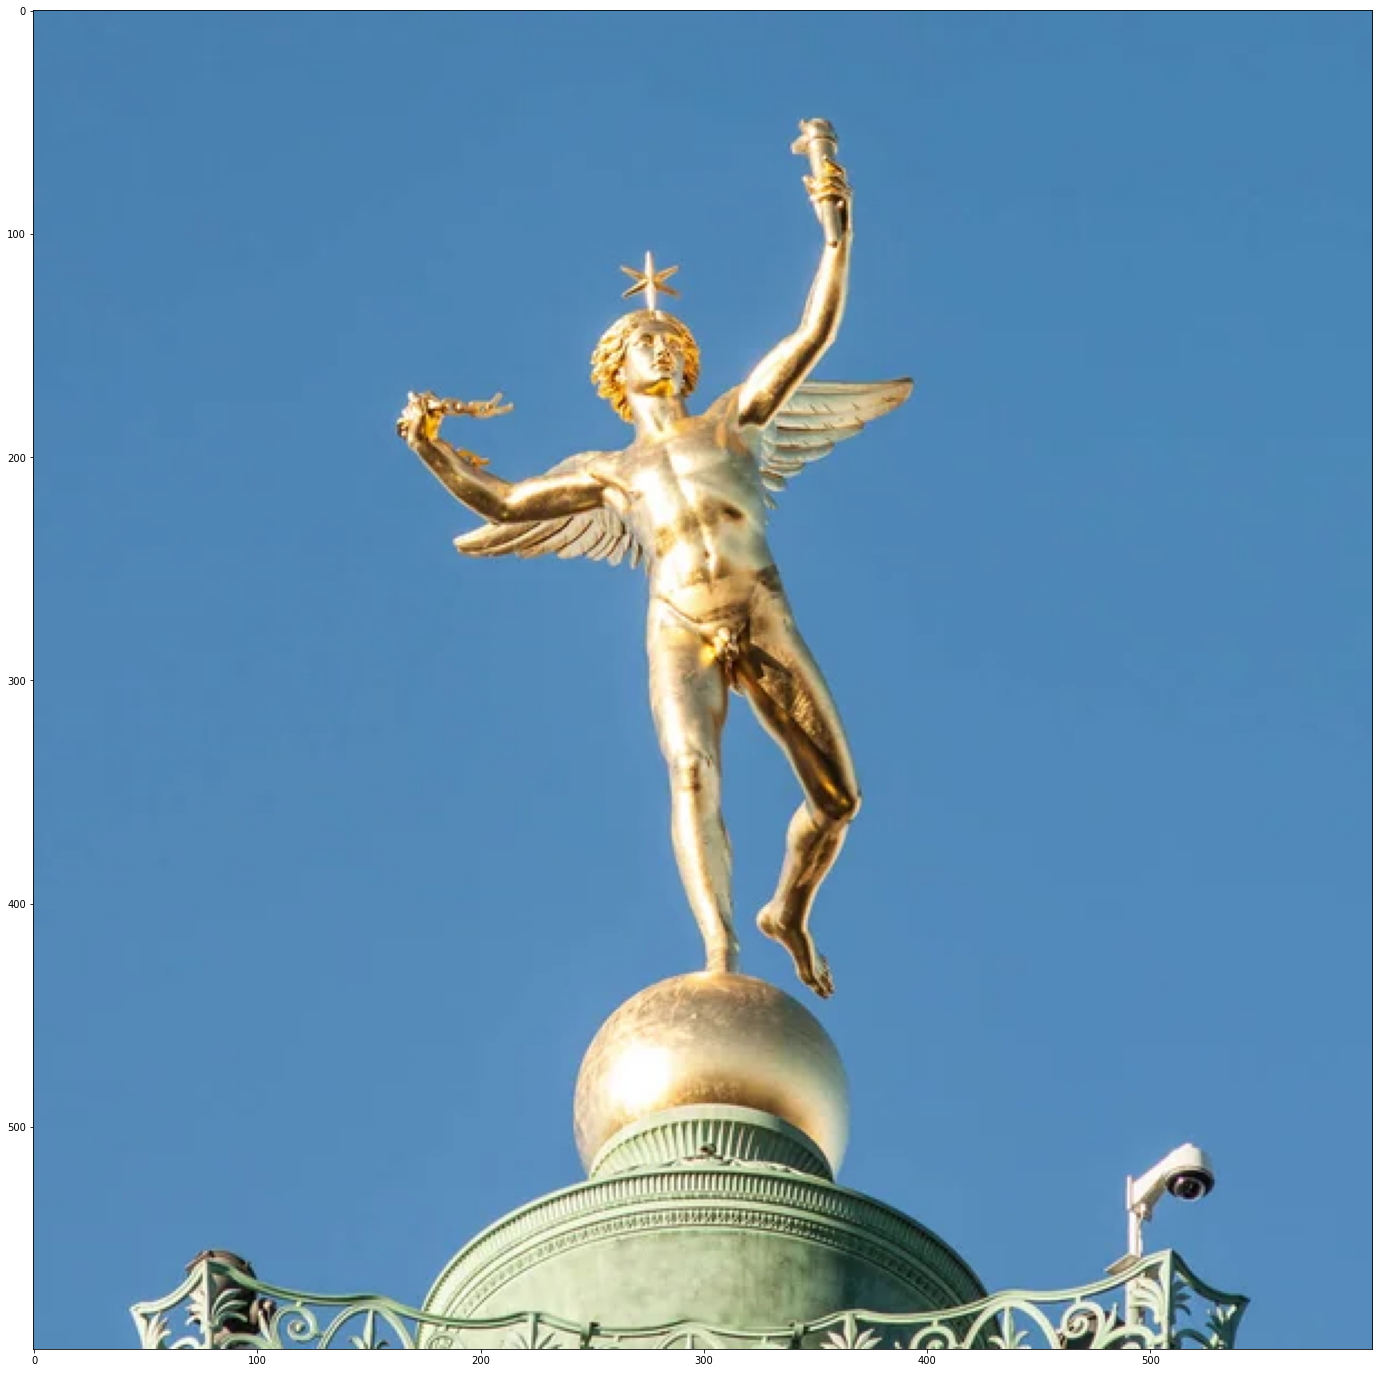

In [33]:
#@title Image Selection (NO TE OLVIDES DE EJECUTAR LA CELDA!) 
selected_image = 'Monumento' #@param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds','Bosque_1','Bosque_2','Edificio_1','Lobo_pre','Pulpo','Montana_2','edificio','Meninos_pre','Montana_1','Monumento','Monumento_2','Tortuga']
flip_image_horizontally = True #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Detectando objetos

Para hacer la inferencia solo necesitamos llamar a nuestro modelo TF Hub recien cargado.

In [35]:
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['raw_detection_scores', 'num_detections', 'detection_multiclass_scores', 'detection_scores', 'raw_detection_boxes', 'detection_boxes', 'detection_anchor_indices', 'detection_classes'])


## Visualizando los resultados

Acá vamos a utilizar la API de detección de objetos de TensorFlow para mostrar los bounding box de las detecciones. 

**TIP**: en la función `visualize_boxes_and_labels_on_image_array()` (linea 15) puede establecer valores diferentes para `min_score_thresh` y `max_boxes_to_draw` para permitir más o menos detecciones en la imagen de salida. La documentación completa de este método se puede ver [acá](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py).


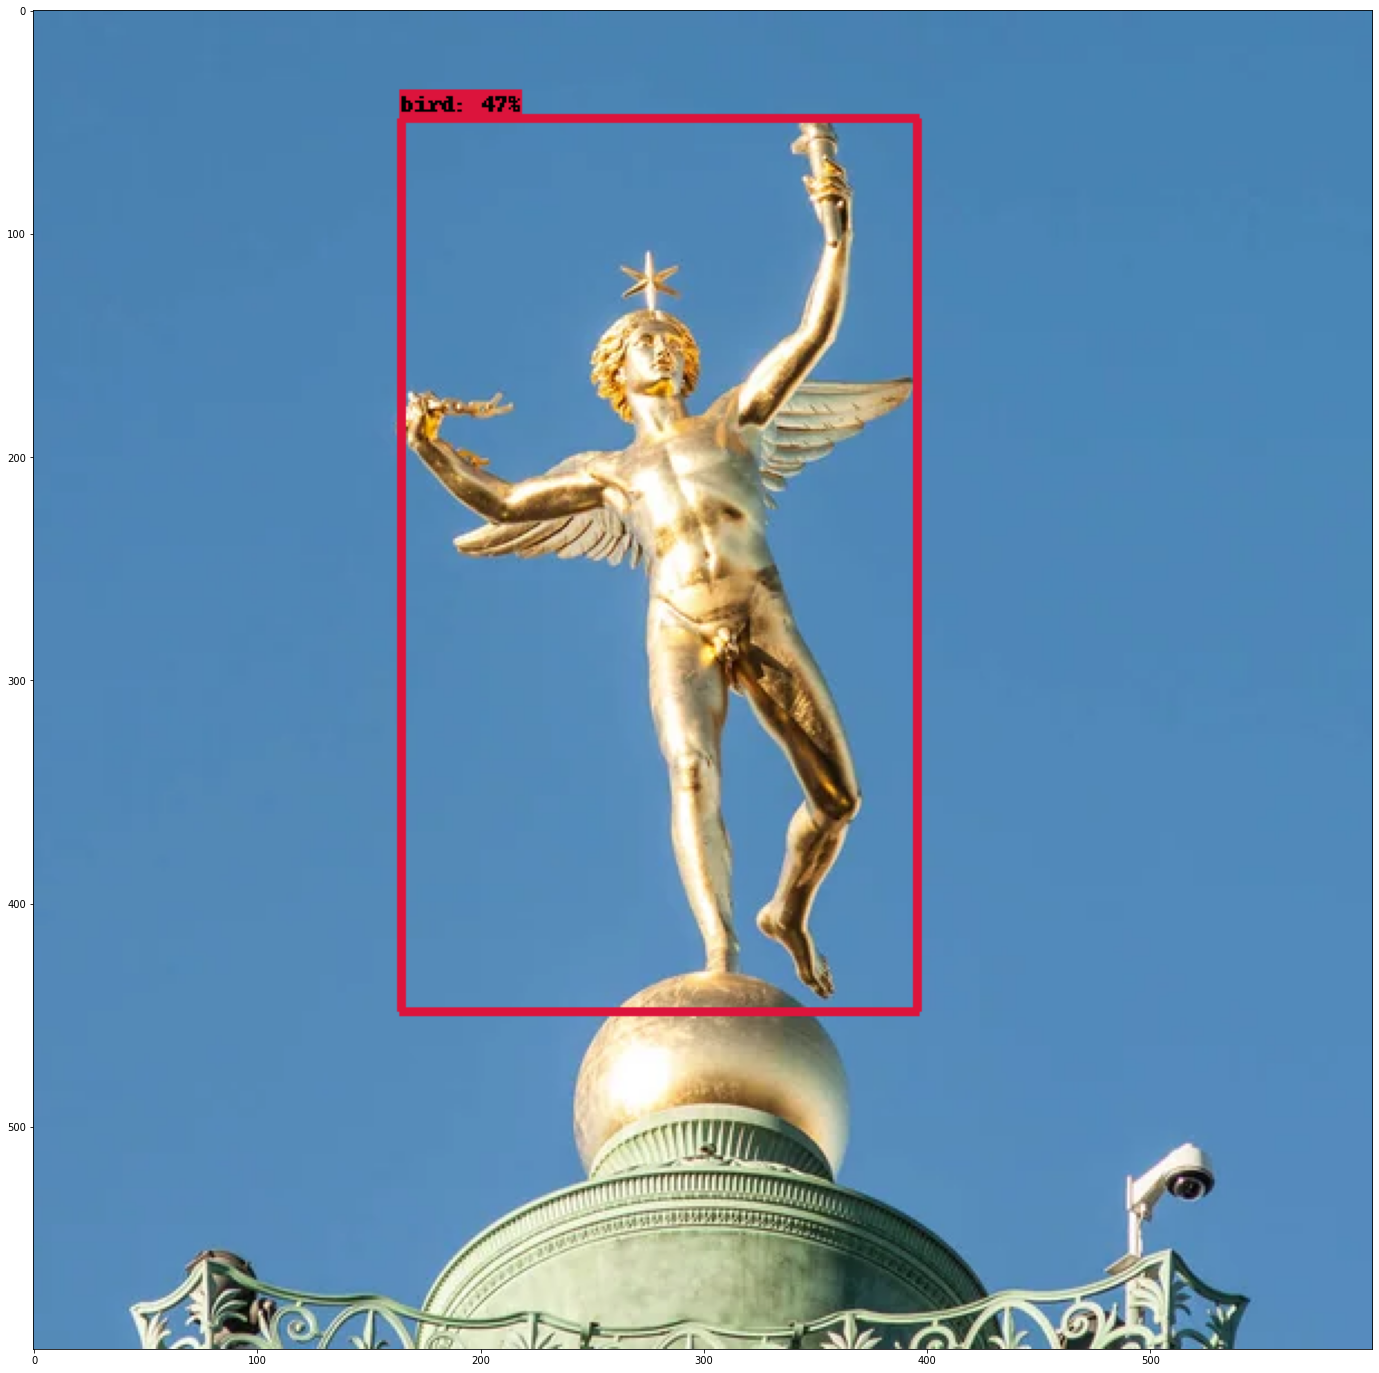

In [36]:
#@title Visualizar los resultados 

label_id_offset = 0 
image_np_with_detections = image_np.copy()

max_boxes_to_draw=200 #@param {type:"slider", min:1, max:300, step:1}
min_score_thresh=0.3 #@param {type:"slider", min:0, max:1, step:0.01}

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=max_boxes_to_draw,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

---

# Trabajo Práctico 2 (primera parte)

**Acá tienen que dejar los datos de las y los integrantes del grupo:**

Nombre y Apellido, DNI, correo eletrónico

---

## **EJERCICIO 4.1**

Ahora vamos a probar algunas varianes simples sobre el tutorial previamente desarrollado. La consigna de este ejercicio es redactar un pequeño informe (celdas de texto en este mismo notebook) sobre los resutlados obtenidos.

1. **Elejir el modelo de detección**. Indague en la web sobre los algoritmos del estado de arte para detección de objetos.
 - ¿Encontrás alguno de estos algoritmos en la lista de modelos disponible en TF Hub? Reportá al menos 3.
 - Seleccioná uno de los tres modelos justificando por que se eligió.
 - Volvé a ejecutar el tutorial para ese modelo

2. **Modificar las imágenes de entrada**. Con este nuevo modelo, volvé a detectar objetos en las imágenes de testeo, pero ahora activá y desactivá los checkbox de la celda donde cargamos las imágenes de prueba. 
 - ¿Notas diferencias en los resultados de detección entre la imagen original y la transformada? Informá cuales son estas diferencias (incluso podés mostrar imágenes con los diferentes resutaldos).

3. **Ejecutar la detección en tus propias imágenes**. Ya comentamos que podés agregar todas las imágenes que quieras en la celda de selección de imágenes testeo. Buscá en la web al menos 2 imágenes de cada una de las siguientes categorías: animales marinos, figuras prediseñadas (dibujos digitales en color o blanco y negro), edificios, monumentos (pirámides, torre Eiffel, Obelisco, etc.), montañas (sin personas, sin objetos hechos por el hombre, etc.), bosques.
 - ¿Que tan bien funciona detectando objetos de estas categorias?
 - ¿Cuál crees que sea el problema de estos modelos para detectar estos objetos? (TIP: podes revisar las características del [dataset COCO 2017](https://cocodataset.org/#explore))

### INFORME EJERCICIO 1
#####***4.1.1***-Realizando una busqueda por al web podemos encontras algunos algoritmos utilizados para la deteccion de imagenes dentro de TensorFlow, estos son:
***SSD***, ***Faster R-CNN***, ***Mask R-CNN***
Juntos con sus variantes.

#####***4.1.2***- Elegimos ***SSD***, mas precisamente este modelo:"SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50) " ya que cuando se publicó a finales de noviembre de 2016 y alcanzó nuevos récords en términos de rendimiento y precisión para las tareas de detección de objetos, con una puntuación de más del 74% de mAP (mean Average Precision )
#####***4.1.3***- Ejecutamos con el nuevo modelo

#####4.2.1- Al destildar el checkBox: "convert_image_to_grayscale", podemos notar que capta otros objetos que no reconocia cuando estaba en escalas de grises:

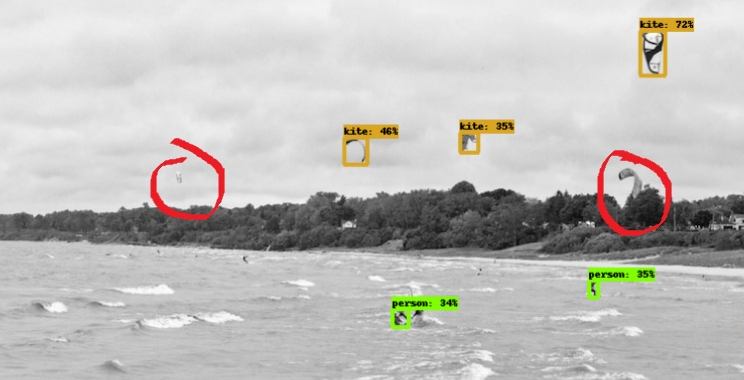

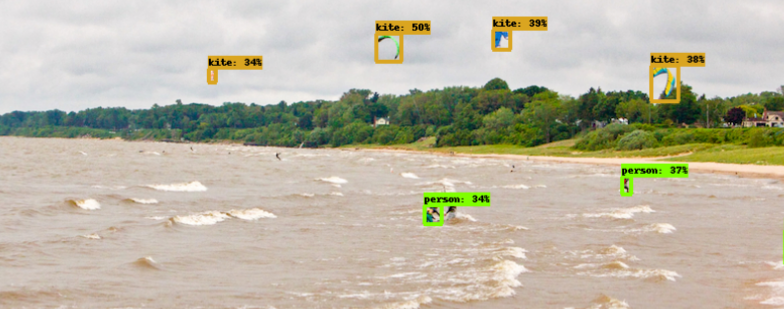



#####***4.3.1***-Agregamos nuevas fotos al dataSet y podemos notar que el modelo no funciona correctame, ya que por ejemplo:las fotografias de los animales maritimos, la tortuga y los peces los detecta como pajaros y a la tortuga como una jirafa con un 42% despues a  la foto de monumento, lo toma tambien como un pajaron con un 47%

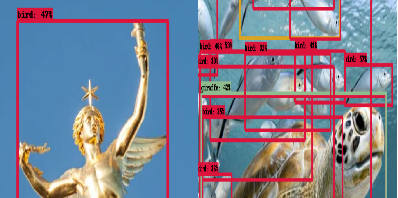

#####***4.3.2***- Unos de los problemas que detectamos es que el modelo no ha sido entrenado con fotos de de animales marinos, como asi tambien con fotos de bosques ni montañas, entonces cuando colocamos nuevas fotos, las interpreta de manera erronea 

## **EJERCICIO 4.2** (Opcional)

Entre los modelos de detección de objetos disponibles se encuentra *Mask R-CNN*. Lo interesante de este modelo es que permite obtener como resultado la máscara de segmentación de instancias.

**CUIDADO**: antes de continuar tenes que ir a la celda de selección de modelos, elegir *Mask R-CNN* y volver a ejecutar esa celda y todas las siguientes (CTRL+F10 desde la celda de selección de modelos)

Para visualizarlo usaremos el mismo método que usamos antes pero agregando un parámetro adicional: `instance_masks=output_dict.get('detection_masks_reframed', None)`



In [ ]:
max_boxes_to_draw=200 #@param {type:"slider", min:1, max:300, step:1}
min_score_thresh=0.3 #@param {type:"slider", min:0, max:1, step:0.01}

# Handle models with masks:
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:
  # we need to convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # Reframe the the bbox mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                      tf.uint8)
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=max_boxes_to_draw,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()

Ahora vamos a visualizar solamente la máscara. Para esto, tenemos que indicar en `detection_masks_reframed` el índice que corresponde a la máscara del objeto que queremos mostrar.

In [ ]:
# #plt.figure(figsize=(24,32))
# plt.imshow(detection_masks_reframed[0])
# plt.show()

Con todo esto, ahora tenemos los primeros elementos para poder evaluar que tan bien funciona el detector de objetos sobre una imágenes en particular. Para esto deben indagar sobre las medidas de rendimiento típicamente utilizadas en la detección de objetos (TIP: buscar IoU y Dice). En la web existen muchos ejemplos de como utilizar estas medidas, incluso hay código disponible. 

A grandes rasgos, la idea de estas medidas es realizar una comparación de la máscara producida por el algoritmo (generalmente nombrada **prediction**) con una máscara hecha a mano (generalmente llamada **groundtruth**). Por lo tanto, el groundtruth es una imagen similar a la que se muestra arriba, pero donde la segmentación la hace una persona. A continuación se deja un ejemplo más concreto, donde se suporpone la imagen original con el groundtruth (izquierda) y la predicción del algoritmo (derecha).

![](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)

El dataset COCO 2017 ofrece máscaras para muchas de sus imágenes.

Por lo tanto, la consigna de este ejercicio es la siguiente:

1. Evalue el rendimiento del modelo sobre un conjunto de imágenes de prueba (TIP: indague métricas para instance segmentation y reutilice código disponible en la web)

2. Reporte los resultados obtenidos